![banner](/custom/banner.png)


# FSLeyes Jupyter notebook


## Help


Use the built-in `help` function to get help on anything in the shell
environment, whether it is a module, function, class, or object:

    help(load)



## Overlays


The `overlayList` is a list which contains all of the overlays that have been
loaded into FSLeyes.  You can load overlays by using the `load` function,
e.g.:

    std = load('MNI152_T1_2mm.nii.gz')


You can remove an overlay simply by removing it from the `overlayList`:

    del overlayList[0]


## Display settings


You can use the `displayCtx` to access the display settings for an
overlay. Display settings for an overlay are divided between two objects:

 - A `Display` object, which contains general display settings
 - A `DisplayOpts` object, which contains display settings specific to the
   overlay type


You can access these objects like so:

    overlay = overlayList[0]
    display = displayCtx.getDisplay(overlay)
    opts    = displayCtx.getOpts(   overlay)


Then adjusting the overlay display settings is easy:


    display.brightness = 75
    opts.cmap          = 'hot'


## FSL commands


Many FSL commands can be called through Python functions, e.g.:

    flirt('src.nii.gz', 'ref.nii.gz', applyxfm=True, init='src2ref.mat')


For commands which produce output images, you can have the outputs loaded
directly into FSLeyes by using the special `LOAD` symbol:

    struc = Image('struct.nii.gz')
    bet(struc, LOAD)


To submit a command as a cluster job, use the `submit` flag:

    fnirt('src.nii.gz', 'ref.nii.gz', submit=True)


## User interface


You can access the current views in FSLeyes through the ``frame`` object:

    ortho = frame.viewPanels[0]


You also can add/remove views through the ``frame``:


    frame.removeViewPanel(ortho)
    frame.addViewPanel(Scene3DPanel)


## Screenshots


To insert a screenshot of the currently displayed scene into the notebook, use
the `screenshot` function:

    ortho = frame.viewPanels[0]
    screenshot(ortho)


## Reproducing a scene


The `getState` function returns a string which describes the current FSLeyes
state. This string describes the current FSLeyes user interface (views,
controls, and toolbars) as well as all loaded overlays and their display
settings.


You can also use the `setState` function to reproduce a previously generated
FSLeyes state.


To make your notebook reproduce your FSLeyes setup, set up your user interface
and overlays how you want, and then call `getState` to get a description of
the current FSLeyes setup:


    getState()


Now copy the string that `getState` generates, and then at the top of your
notebook add a call to `setState`, passing in that string, e.g.:

    fsleyesState = 'OrthoPanel\nlayout2|name=OrthoPanel 1;caption=...'
    setState(fsleyesState)


## For more information

See the FSLeyes and `fslpy` API documentation:

 - https://open.win.ox.ac.uk/pages/fsl/fsleyes/fsleyes/apidoc/
 - https://open.win.ox.ac.uk/pages/fsl/fslpy/

### 1. Load data and visualization

In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# Imports for visualization
def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

In [2]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [6]:
#loading the data
subject = '02'

In [3]:
import nibabel as nib
%matplotlib inline

def load_func_data(subject, run) :
    bids_root = op.join(os.path.abspath(""), "miniproject_icafunc_bold")
    deriv_root = op.join(bids_root, 'derivatives')
    func_path = op.join(deriv_root, 'sub-'+ subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    return op.join(func_path, file_name) 
    
def load_event(subject, run) :
    bids_root = op.join(os.path.abspath(""), "miniproject_ica_events")
    func_path = op.join(bids_root, 'sub-'+subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_events.tsv"
    return op.join(func_path, file_name) 
    
def load_anat_data(subject) :
    sample_path = "miniproject_ica_data_anat"
    bids_root = op.join(os.path.abspath(""), sample_path)
    deriv_root = op.join(bids_root, 'derivatives')
    anat_path = op.join(deriv_root, 'sub-'+ subject, 'anat')
    file_name = "sub-"+ subject + "_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    return op.join(anat_path, file_name)
    

def load_data(path:str) -> np.ndarray :
    img = nib.load(path)
    data = np.asanyarray(img.dataobj)
    return data

def load_data_event(event_path):
    return pd.read_csv(event_path, sep='\t')

def plot_anat(data : np.ndarray, title, slice : int = None) -> None : 
    
    sub_title = ["sagittal view", "coronal view", "axial view" ]


    fig, ax = plt.subplots(1,3, figsize=(9, 3))
    fig.tight_layout()
    for i, ax in enumerate(ax):
        if slice == None :
            s = int(data.shape[i]/2)
        else :
            s = slice
        ax.imshow(np.rot90(data.take(s,axis=i)), cmap="gray", aspect="auto")
        ax.set_title(sub_title[i])
    fig.suptitle(title, x=0.5, y=1.2)
    plt.show()

#### Visualize anat

In [7]:
anat_sub_02_path = load_anat_data(subject)

In [8]:
reset_overlays()
load(anat_sub_02_path)

NameError: name 'reset_overlays' is not defined

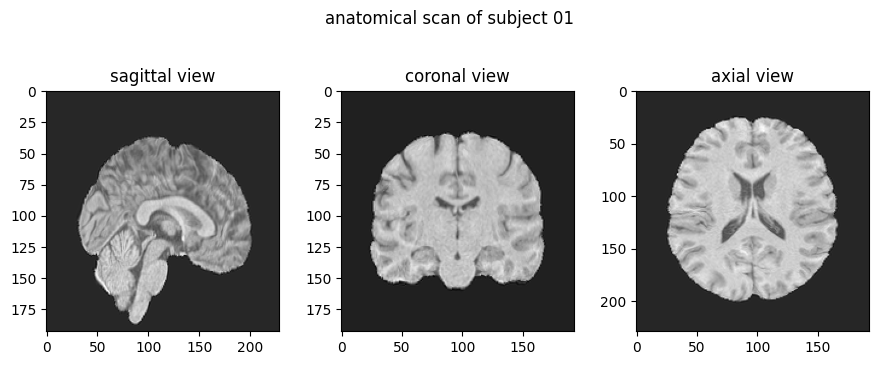

In [9]:
anat_sub_02 = load_data(anat_sub_02_path)
plot_anat(anat_sub_02, "anatomical scan of subject 01")

#### Visualize Func data

In [10]:
func_sub_02_path = load_func_data(subject, "001")

In [ ]:
reset_overlays()
load(func_sub_02_path)

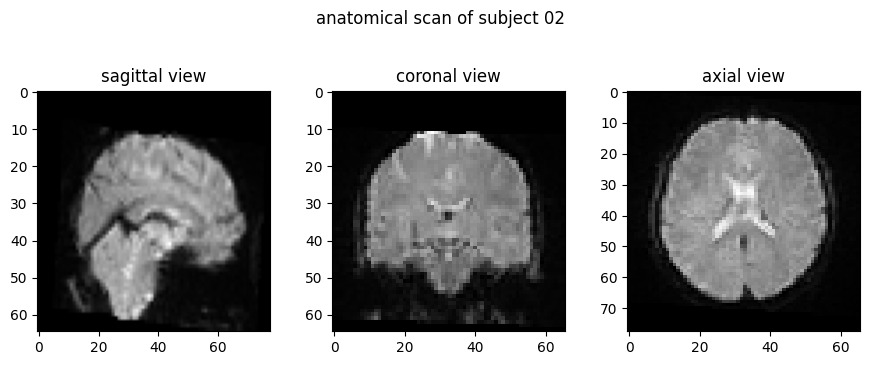

In [12]:
func_sub_02 = load_data(func_sub_02_path)
plot_anat(func_sub_02[:,:,:,121], "anatomical scan of subject 02")

In [13]:
func_sub_16_path = load_func_data("16", "001")
func_sub_16 = load_data(func_sub_16_path)
func_sub_16.shape

(66, 78, 65, 242)

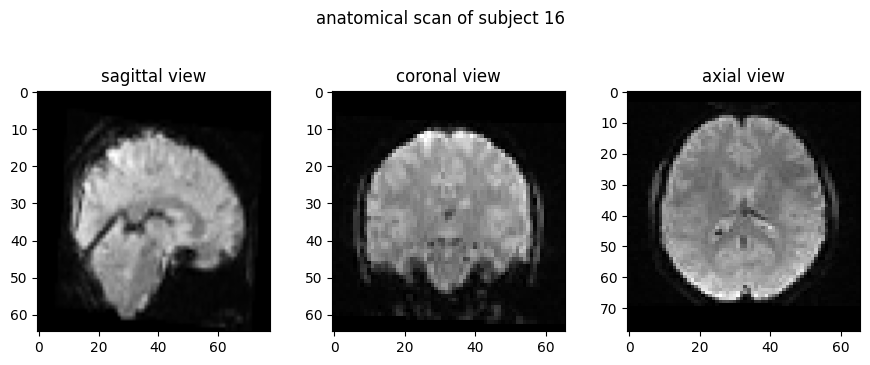

In [14]:
plot_anat(func_sub_16[:,:,:,121], "anatomical scan of subject 16")

In [15]:
import pandas as pd

event_sub_02_path = load_event(subject, "001")
    
event_sub_02 = load_data_event(event_sub_02_path)
#Shape (21, 3)
#event_sub_02.shape
#Type pandas.core.frame.DataFrame
#type(event_sub_02)


#Display DataFrame values
pd.set_option("display.max.columns", None)
event_sub_02.head(event_sub_02.shape[0])
#event_sub_02.shape[0] is necessary to plot every rows, by default only the first 5 are plotted

,onset,duration,trail_type
0,0,120,full_circular_checkerboard
1,120,16,white_fixation
2,136,32,full_circular_checkerboard
3,168,16,white_fixation
4,184,32,full_circular_checkerboard
5,216,16,white_fixation
6,232,32,full_circular_checkerboard
7,264,16,white_fixation
8,280,32,full_circular_checkerboard
9,312,16,white_fixation


In [14]:
# TODO : Figure comparer participant

In [82]:
# not the same shape between functionnal and anatomical : not same RESOLUTION 
# image align yes ! : check if each patient is align, if not remove it : figure ?

### 2) Apply group ICA 

In [16]:
bids_root = op.join(os.path.abspath(""), "miniproject_icafunc_bold")
deriv_root = op.join(bids_root, 'derivatives')

In [17]:
# Prepare data

path_func_img = func_sub_02_path
img_ex = nib.load(path_func_img)

# Get affine transform -- check nibabel library for more info!
affine = nib.load(path_func_img).affine
x,y,z,v = img_ex.shape
print(x,y,z,v)

N_vol=242
N_subj=3
N_tot=N_vol*N_subj

#* Initialize X
size = x*y*z
X_data = np.zeros((N_tot,size)) # total_timepoints(2subj*242timepoints) x voxel_num
i = 0
n_nii  = 0
nb_subj_counted=0
for root, dirs, files in sorted(os.walk(deriv_root)):
    print(files)
    if len(files)!= 0:
        nb_subj_counted=nb_subj_counted+1 
        print(f"Loading subject {nb_subj_counted}")
    for j in range(len(files)):
        file = sorted(files)[j]
        if file.endswith('.nii.gz') and file.partition("run-")[2][0:3] == "001": # do we need to do it for all run ??
            if nb_subj_counted<N_subj+1:
                print("file",file)
                
                data = nib.load(root+'/'+file).get_fdata().reshape(size, -1).T
                
                #apply mask first to gain ram !
                # s_img = nib.Nifti1Image(data, affine)
                # print(s_img.shape)

                # data = masker.fit_transform(s_img)
                # masked_ = masker.inverse_transform(data) # mask the components
                # print(masked_.shape)
                # data = masked_
                
                #standardize
                row_means = np.mean(data, axis=1).reshape(-1,1)
                row_std = np.std( data, axis = 1).reshape(-1,1)
                data= data - row_means / row_std

                X_data[n_nii : n_nii + N_vol, :] = data
                n_nii+=N_vol
                print(n_nii)

X_data = zscore(X_data, axis = 1) # across subjects
X_data = np.nan_to_num(X_data,0) # nan to 0s
print("X matrix size: ", X_data.shape)

66 78 65 242
[]
[]
['sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-02_task-fullchecker_run-002_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'sub-02_task-fullchecker_run-002_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
Loading subject 1
file sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
file sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
242
[]
['sub-05_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'sub-05_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-05_task-fullchecker_run-002_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'sub-05_task-fullchecker_run-002_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
Loading subject 2
file sub-05_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold

In [18]:
np.where(np.mean(X_data, axis = 1)  == 10**-15) #verify normalisation

(array([], dtype=int64),)

In [19]:
S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,10]#20, 60 ...]


for n in nb_components:
    print(f"Processing component {n}")
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(X_data.T)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components
(334620, 4)
Done
Processing component 10
Running FastICA with n = 10 components
(334620, 10)
Done


In [20]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (334620, 10)


### 3- Visualization

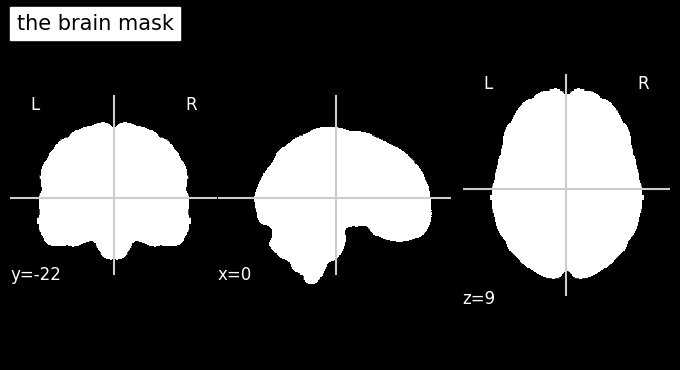

In [21]:
#* Build brain mask to restrict analysis within the brain
icbms = datasets.fetch_icbm152_2009() # find a betetr mask or create one
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

In [22]:
print(affine)
bg = nib.load(anat_sub_02_path)
print(bg.shape)

[[   2.9690001    0.           0.         -96.5      ]
 [   0.           2.9690001    0.        -132.5      ]
 [   0.           0.           3.         -78.5      ]
 [   0.           0.           0.           1.       ]]
(193, 229, 193)


Number of components:  4
(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


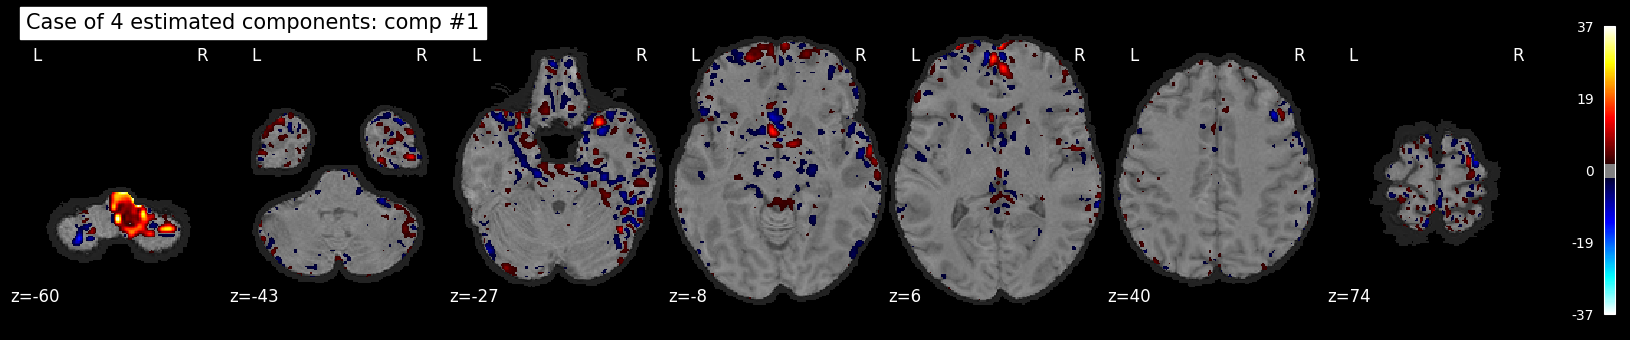

(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


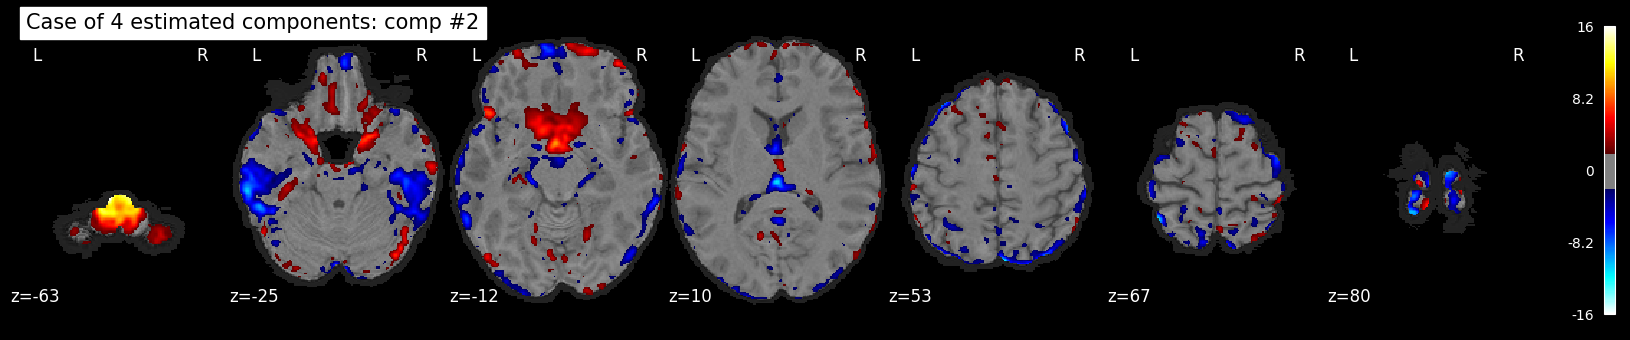

(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


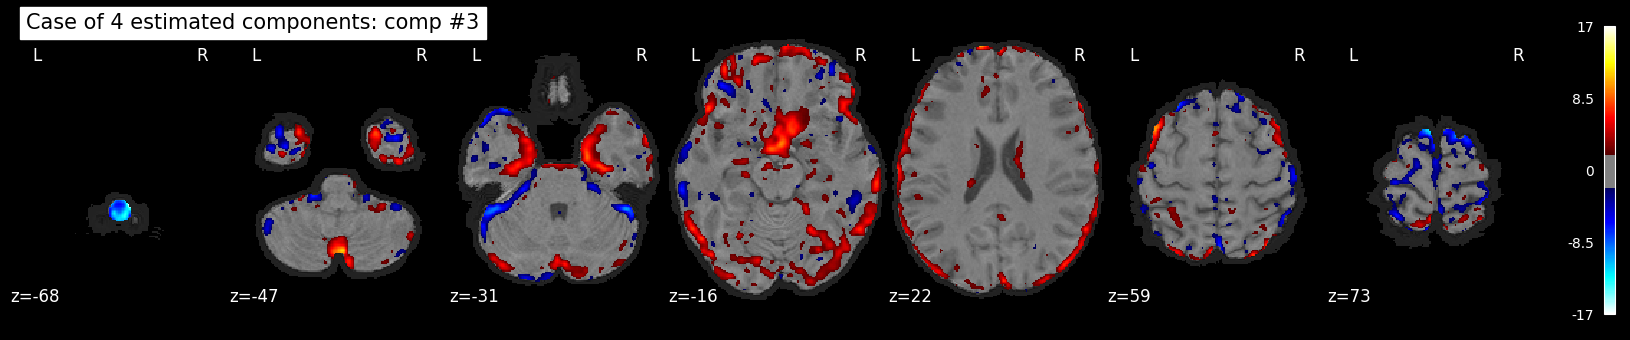

(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


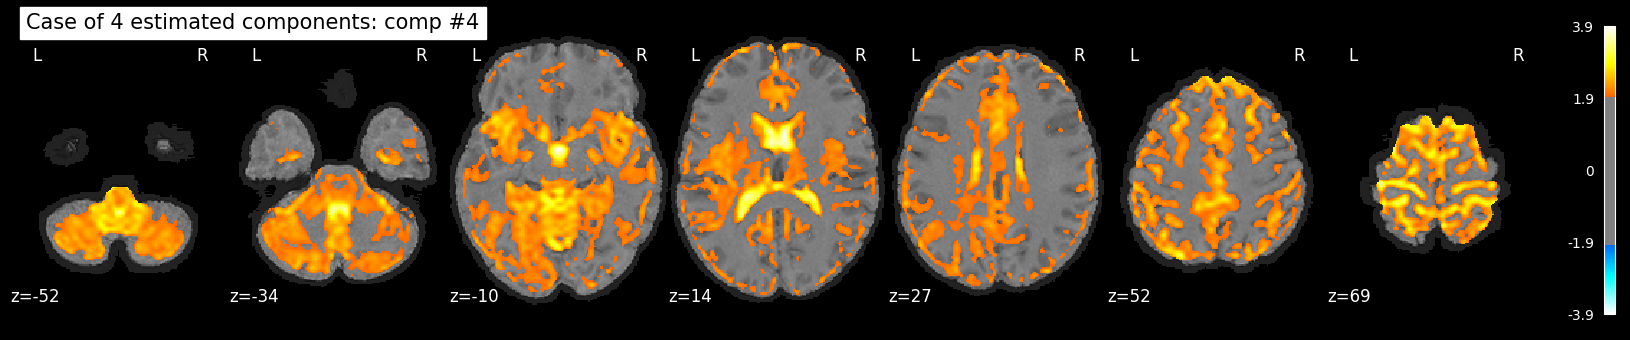

In [23]:
def ICA_plot (nb_components, data_dict, mask) :

    for n in nb_components[0:1]:
        print('Number of components: ', n)
        S_ = data_dict[n].copy()
        for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
            s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
            print(s_img.shape)
            data = mask.fit_transform(s_img)
            masked_ = masker.inverse_transform(data) # mask the components
            print(masked_.shape)
            plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                          colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=bg,)
                          #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
            plt.show()

ICA_plot(nb_components, S_dict, masker)

Number of components:  4


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


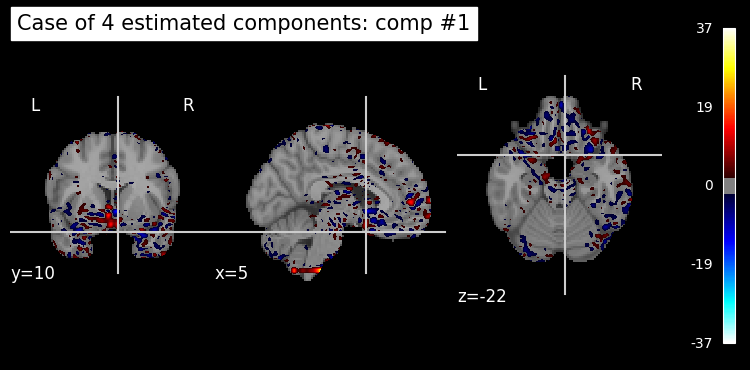

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


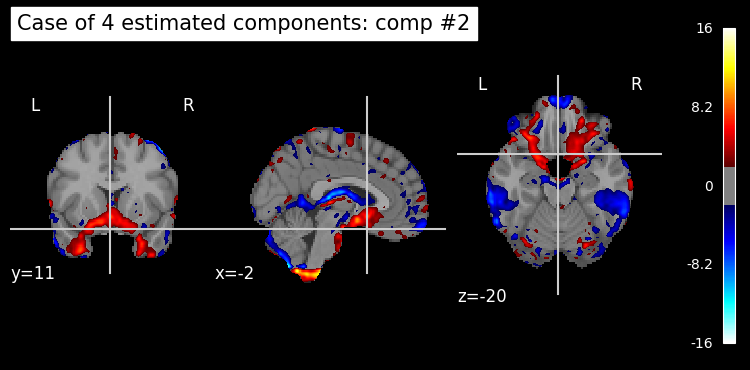

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


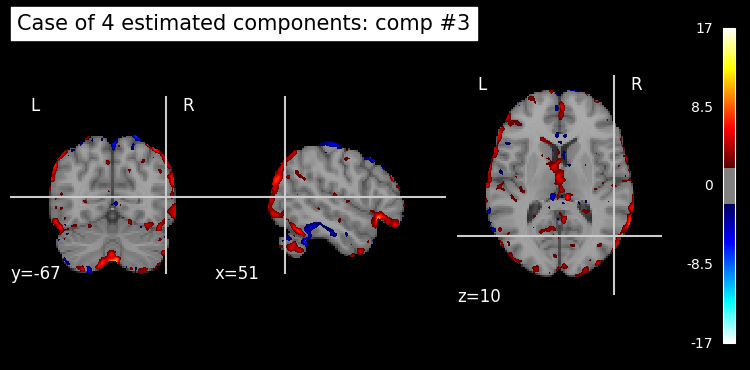

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


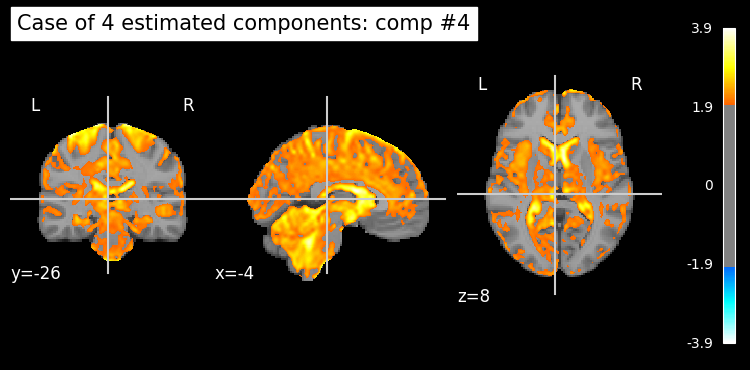

Number of components:  10


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


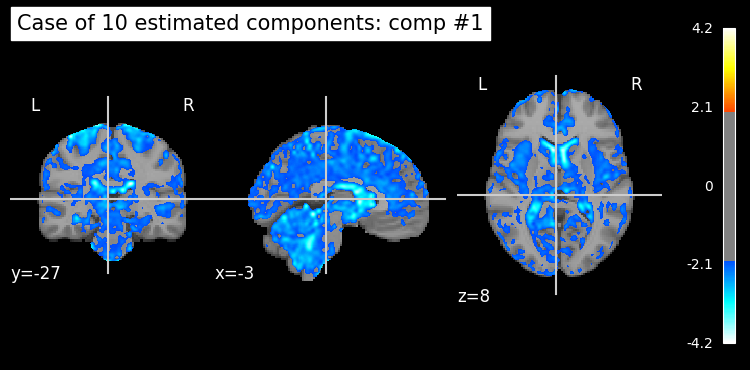

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


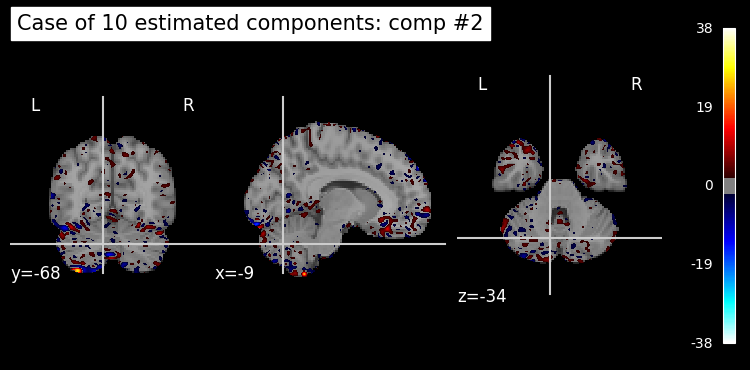

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


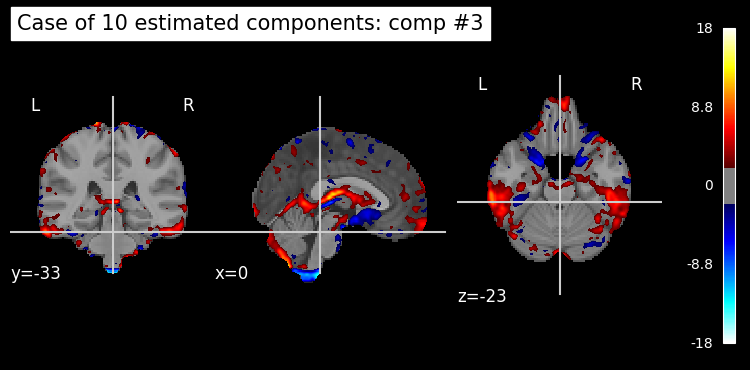

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


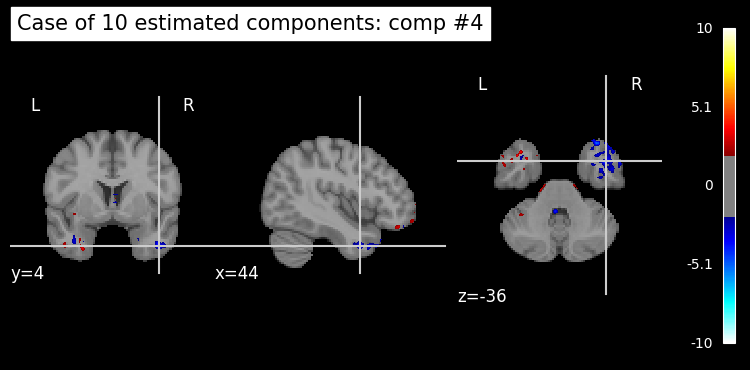

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


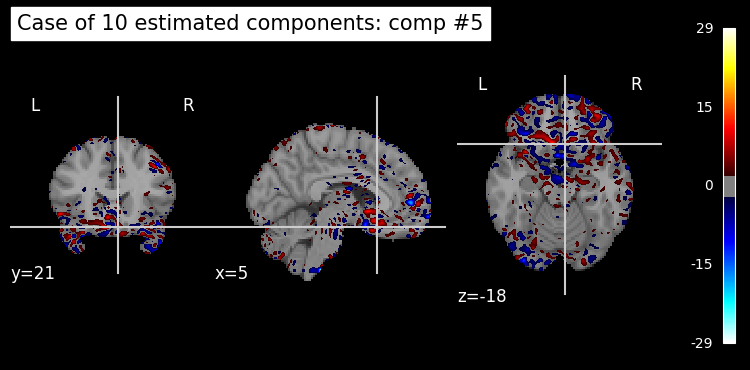

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


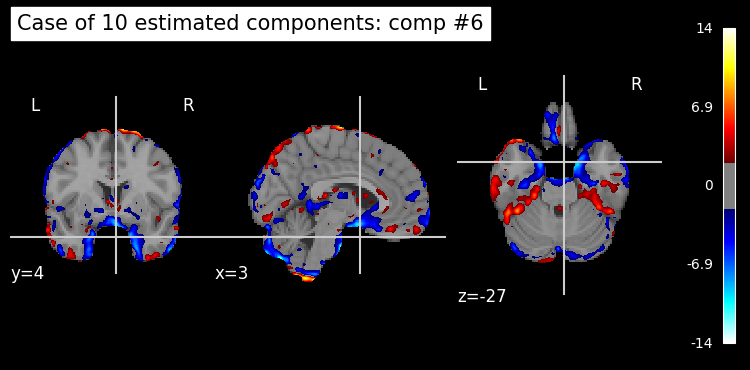

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


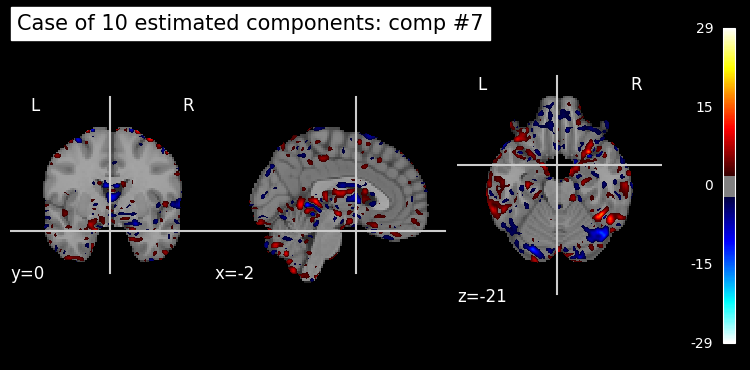

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


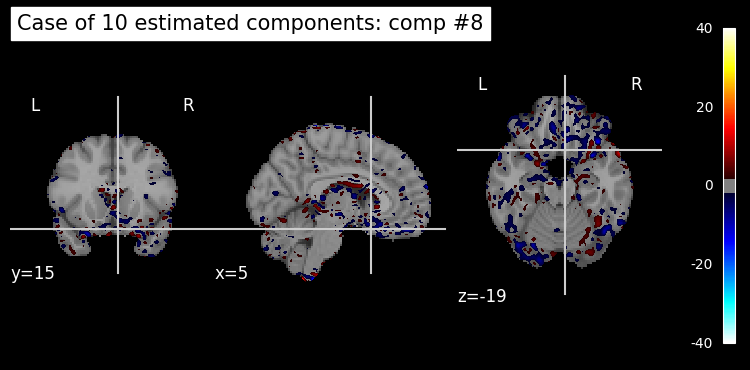

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


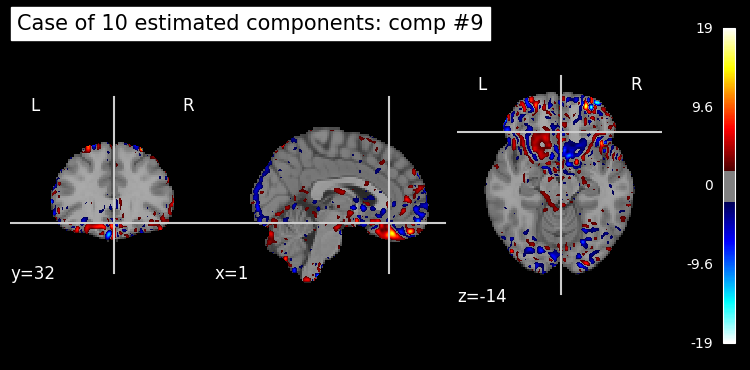

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


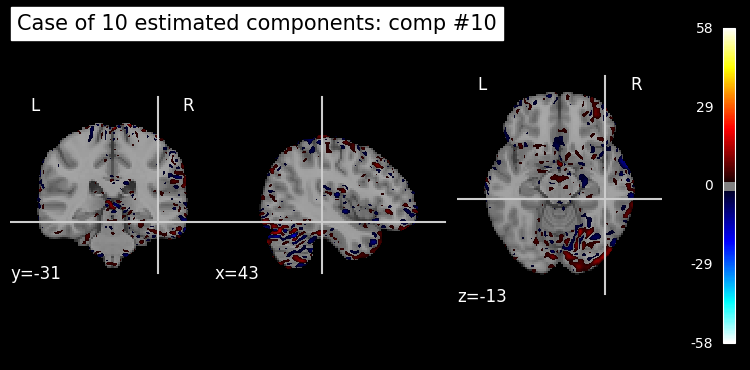

In [24]:
#* Not needed 
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s))
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

### 4- TImeCourse

In [25]:
# Let's visualize the corresponding timecourses when nb_comp=...

timecourse_dict = {}
# As was done in the above visualization, we are interested in voxels above 2 standard deviations
for nbcomp in nb_components :
    associated_timecourses = []
    S_ = S_dict[nbcomp].copy()
    print(f"The number of components you visualize are {nbcomp}")
    for cidx in range(nbcomp):
        threshold = np.std(S_[:,cidx])
        s_comp = np.reshape(S_[:,cidx], (x,y,z))
        thresh_mask = s_comp > threshold

        # Original timecourse - prior to PCA which we used to simplify spatial patterns
        t_comp = X_data.reshape(N_tot, x,y,z)[:,thresh_mask].mean(axis=1) # Averaging voxel-wise for a single representative timecourse
        associated_timecourses.append(t_comp)
    timecourse_dict[nbcomp] = associated_timecourses



The number of components you visualize are 4
The number of components you visualize are 10


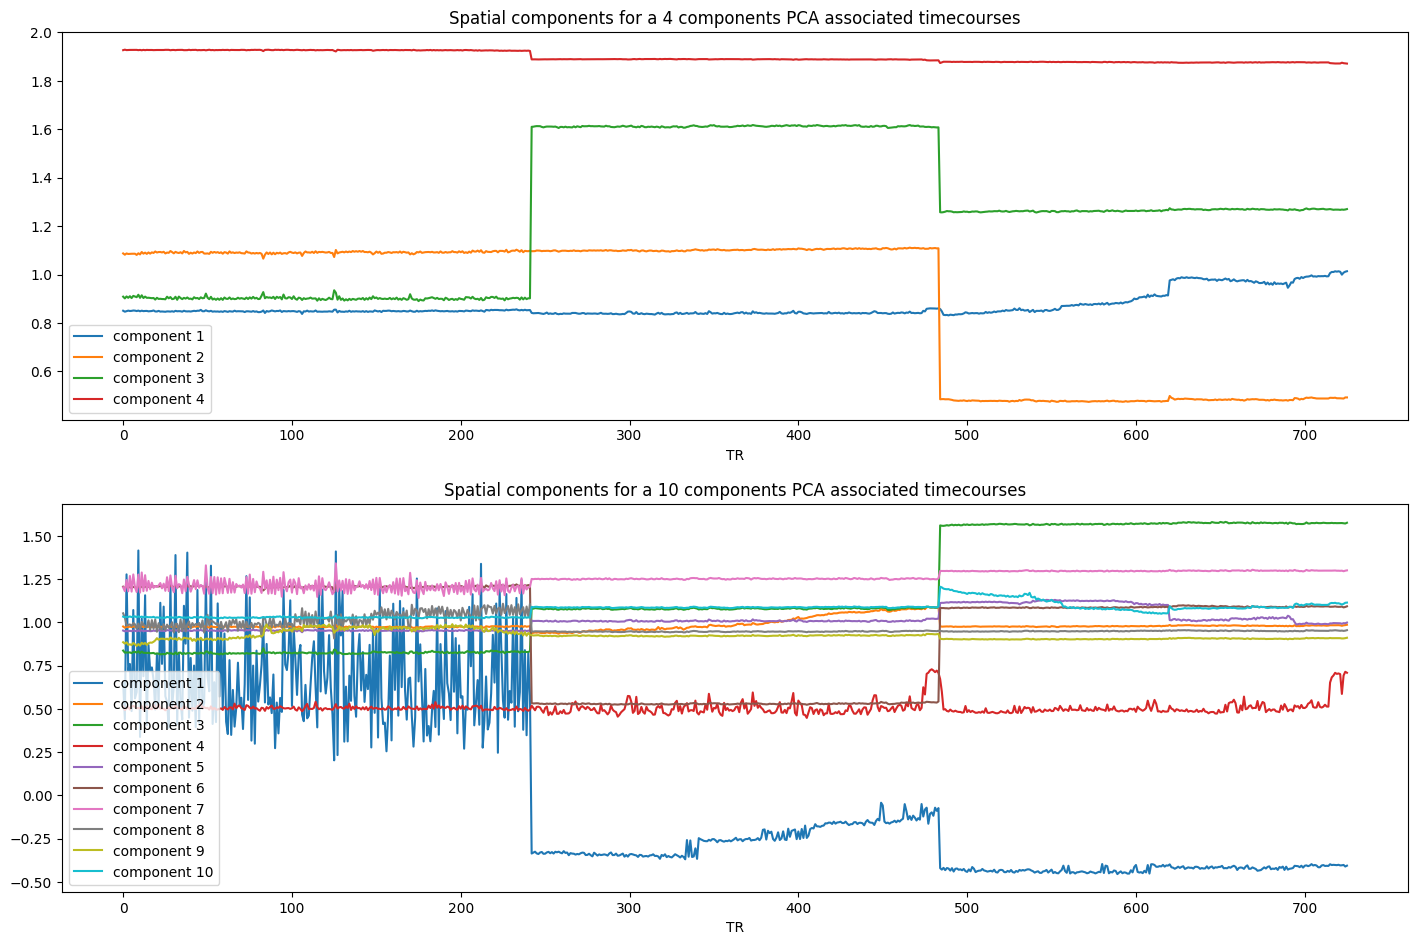

In [26]:
fig, ax = plt.subplots(2, figsize=(15,10))
fig.tight_layout(pad=4.0)

for i, nbcomp in enumerate(nb_components) : 
    assoc_timecourses = timecourse_dict[nbcomp]
    for cidx in range(nbcomp):
        ax[i].plot(assoc_timecourses[cidx], label=f'component {cidx+1}')

        ax[i].legend()
        ax[i].set_xlabel('TR')
        ax[i].set_title(f'Spatial components for a {nbcomp} components PCA associated timecourses')
plt.show()

In [85]:
# How to interpret these graph ? What are the axis ?

### 5- PCA

In [86]:
subject = '02' 
pca_path_func_data = load_func_data(subject, "001")
img = nib.load(pca_path_func_data)
data_pca = np.asanyarray(img.dataobj)
data_pca.shape

(66, 78, 65, 242)

In [88]:
vol_shape = data_pca.shape[:-1]
n_vols = data_pca.shape[-1]
vol_shape = data_pca.shape[:-1]
print(vol_shape, n_vols)

(66, 78, 65) 242


In [89]:
N = np.prod(vol_shape)
data_pca = data_pca.reshape((N, n_vols))
# Transpose to 242 by N array
data_pca = data_pca.T
# Calculate the mean across columns
row_means = np.mean(data_pca, axis=1)
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
# Subtract the means for each row, put the result into X
X = data_pca - row_means
print(X.shape)

(242, 334620)


In [90]:
# Compute the covariance matrix 
covariance_matrix = X.dot(X.T)

# Apply SVD to get U, S, VT matrices from covariance matrix
U, S, VT = np.linalg.svd(covariance_matrix)
print(n_vols)

242


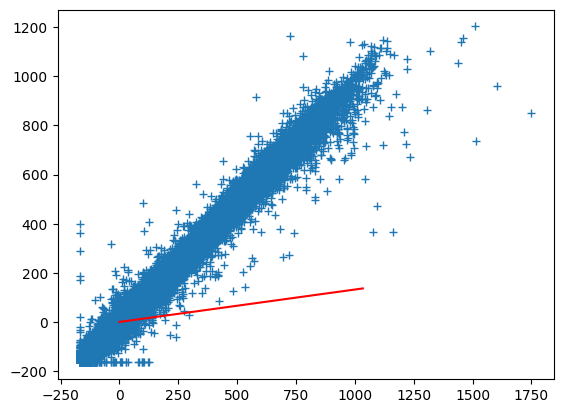

In [91]:
# Plot line corresponding to a scaled version of the first principal component
plt.plot(X[0], X[1], '+')
scaled_u = U[0, :] * -16000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r')

In [92]:
C = U.T.dot(data_pca)
C.shape


(242, 334620)

In [93]:
# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(vol_shape + (n_vols,))
C_vols.shape

#- Break 4D array into two 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

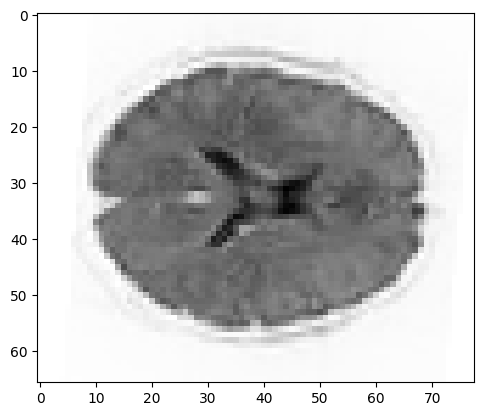

In [94]:
plt.imshow(vol0[:, :, 32], cmap='gray')

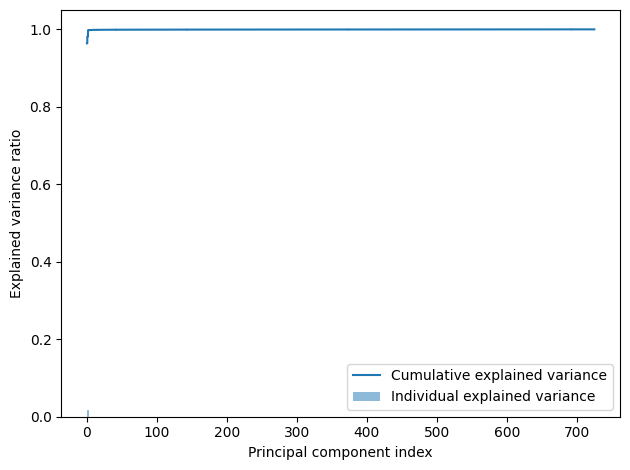

In [28]:
pca = PCA()

X_train_pca = pca.fit_transform(X_data.T)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [30]:
#* Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,10]#20, 60 ...]


for n in nb_components:
    print(f"Processing component {n}")
    
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    pca = PCA(0.25)
    H = pca.fit_transform(X_data.T)  # Reconstruct signals based on orthogonal components
    ### END SOLUTION
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components
(334620, 1)
Done
Processing component 10


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\sklearn\decomposition\_fastica.py:582: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(


Running FastICA with n = 10 components
(334620, 1)
Done


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\sklearn\decomposition\_fastica.py:582: UserWarning: n_components is too large: it will be set to 1
  warnings.warn(
